# **Memory**

Memory is a cognitive function that allows people to store, retrieve, and use information to understand their present and future. Consider the frustration of working with a colleague who forgets everything you tell them, requiring constant repetition! As AI agents undertake more complex tasks involving numerous user interactions, equipping them with memory becomes equally crucial for efficiency and user satisfaction. With memory, agents can learn from feedback and adapt to users' preferences. 

Most LLM applications have a conversational interface. An essential component of a conversation is being able to refer to information introduced earlier in the conversation. At bare minimum, a conversational system should be able to access some window of past messages directly. A more complex system will need to have a world model that it is constantly updating, which allows it to do things like maintain information about entities and their relationships.

We call this ability to store information about past interactions "memory". 

## **Building memory into a system**
The two core design decisions in any memory system are:
- How state is stored
- How state is queried

## **Depricated**
- ConversationBufferMemory
- ConversationStringBufferMemory
- ConversationBufferWindowMemory
- ConversationTokenBufferMemory
- ConversationSummaryMemory
- ConversationSummaryBufferMemory
- VectorStoreRetrieverMemory

## **What's covered?**
- Designing Memory - Buidling End-to-end Conversational AI Bot
- Saving and Loading a Chat History
- SQLChatMessageHistory and Adding Session ID
- Introduction to LangGraph for Memory

## **Designing Memory - Buidling End-to-end Conversational AI Bot**

<img src="images/memory.png">

### **Steps:**
1. Import Chat Model and Configure the API Key
2. Create Chat Template
3. Create a Output Parser
4. Initialize the Memory
5. Build a Chain
6. Invoke the chain with human_input and chat_history
7. Saving to memory
8. Run Step 6 and 7 in a loop

In [1]:
# Step 1 - Import Chat Model and Configure the API Key

from langchain_openai import ChatOpenAI

# Setup API Key
f = open('keys/.openai_api_key.txt')
OPENAI_API_KEY = f.read()

# Set the OpenAI Key and initialize a ChatModel
chat_model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)

/Users/kanavbansal/Developer/.env_jupyter/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Step 2 - Create Chat Template

from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder

chat_template = ChatPromptTemplate.from_messages(
    [
        # The persistent system prompt
        SystemMessage(
            content="You are a chatbot having a conversation with a human."
        ),
        # Creating a chat_history placeholder
        MessagesPlaceholder(
            variable_name="chat_history"
        ),  
        # Human Prompt
        HumanMessagePromptTemplate.from_template(
            "{human_input}"
        ),
    ]
)

In [3]:
# Step 3 - Create a Output Parser

from langchain_core.output_parsers import StrOutputParser

output_parser = StrOutputParser()

In [4]:
# Step 4 - Initialize the Memory
from langchain_core.runnables import RunnableLambda

memory_buffer = {"history": []}

def get_history_from_buffer(human_input):
    return memory_buffer["history"]

runnable_get_history_from_buffer = RunnableLambda(get_history_from_buffer)

#### **RunnablePassthrough:** RunnablePassthrough on its own allows you to pass inputs unchanged.

In [5]:
# Step 5 - Build a Chain (Another way)
from langchain_core.runnables import RunnablePassthrough

# Define a chain
chain = RunnablePassthrough.assign(
        chat_history=runnable_get_history_from_buffer
        ) | chat_template | chat_model | output_parser

In [6]:
# Step 6 - Invoke the chain with human_input and chat_history

query = {"human_input": "Hi, How are you?"}

response = chain.invoke(query)

response

"Hello! I'm just a computer program so I don't have feelings, but I'm here and ready to help you with anything you need. How can I assist you today?"

In [7]:
memory_buffer

{'history': []}

In [8]:
# Step 7 - Saving to memory
from langchain_core.messages import HumanMessage, AIMessage

memory_buffer["history"].append(HumanMessage(content=query["human_input"]))
memory_buffer["history"].append(AIMessage(content=response))

memory_buffer

{'history': [HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm just a computer program so I don't have feelings, but I'm here and ready to help you with anything you need. How can I assist you today?", additional_kwargs={}, response_metadata={})]}

In [10]:
# Step 8 - Run Step 6 and 7 in a loop

while True:
    query = {"human_input" : input('Enter your input: ')}
    print(f"*User: {query['human_input']}")
    if query["human_input"] in ['bye', 'quit', 'exit']:
        break
    response = chain.invoke(query)
    print(f"*AI: {response}")

    memory_buffer["history"].append(HumanMessage(content=query["human_input"]))
    memory_buffer["history"].append(AIMessage(content=response))

Enter your input:  My name is Kanav


*User: My name is Kanav
*AI: Hello Kanav! It's nice to meet you. How can I assist you today?


Enter your input:  just exploring


*User: just exploring
*AI: That's great! Feel free to ask me anything or share any topics you'd like to explore. I'm here to help and provide information.


Enter your input:  that's good to know


*User: that's good to know
*AI: I'm glad to hear that! If you have any questions or need assistance, don't hesitate to ask. I'm here to help.


Enter your input:  what;s my name?


*User: what;s my name?
*AI: Your name is Kanav.


Enter your input:  exit


*User: exit


In [11]:
memory_buffer["history"]

[HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you. How can I help you today?", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='My name is Kanav', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Hello Kanav! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='just exploring', additional_kwargs={}, response_metadata={}),
 AIMessage(content="That's great! Feel free to ask me anything or share any topics you'd like to explore. I'm here to help and provide information.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="that's good to know", additional_kwargs={}, response_metadata={}),
 AIMessage(content="I'm glad to hear that! If you have any questions or need assistance, don't hesitate to ask. I'm here to help.", 

## **Saving a Chat History**

**Let's now learn to save this history on the disk so that whenever we can load the history whenever we chat with our assistant.**

In [12]:
import pickle

chat_history = pickle.dumps(memory_buffer)

with open("chats_data/conversation_memory.pkl", "wb") as f:
    f.write(chat_history)

## **Loading a Chat History**

In [13]:
chat_history_loaded = pickle.load(open("chats_data/conversation_memory.pkl", "rb"))

In [14]:
chat_history_loaded

{'history': [HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to assist you. How can I help you today?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='My name is Kanav', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello Kanav! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='just exploring', additional_kwargs={}, response_metadata={}),
  AIMessage(content="That's great! Feel free to ask me anything or share any topics you'd like to explore. I'm here to help and provide information.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content="that's good to know", additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm glad to hear that! If you have any questions or need assistance, don't hesitate to ask. I

## **SQLChatMessageHistory**

`ChatMessageHistory` allows us to store separate conversation histories per user or session which is often done by the real-time chatbots. `session_id` is used to distinguish between separate conversations.

In order to use it, we can use a `get_session_history` function which take `session_id` and returns a message history object.

There is a support of many `Memory` components under `langchain_community.chat_message_histories`, like:
1. AstraDBChatMessageHistory
2. DynamoDBChatMessageHistory
3. CassandraChatMessageHistory
4. ElasticsearchChatMessageHistory
5. KafkaChatMessageHistory
6. MongoDBChatMessageHistory
7. RedisChatMessageHistory
8. PostgresChatMessageHistory
9. SQLChatMessageHistory

**[Click Here](https://python.langchain.com/v0.2/docs/integrations/memory/)** to read more.

### **Usage**

To use the storage you need to provide only 2 things:

1. **Session Id** - a unique identifier of the session, like user name, email, chat id etc.
2. **Connection string**
    - For SQL (SQLAlchemy) - A string that specifies the database connection. It will be passed to SQLAlchemy create_engine function.
    - For SQLite - A string that specifies the database connection. For SQLite, that string is slqlite:/// followed by the name of the database file. If that file doesn't exist, it will be created.

In [16]:
from langchain_community.chat_message_histories import SQLChatMessageHistory

In [17]:
# Set the OpenAI Key and initialize a ChatModel

from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)

In [18]:
# Create a connection with the database and 
# return the chat message history for a session id

from langchain_community.chat_message_histories import SQLChatMessageHistory

def get_session_message_history_from_db(session_id):
    chat_message_history = SQLChatMessageHistory(
                                   session_id=session_id, 
                                   connection="sqlite:///chats_data/sqlite.db"
                               )
    return chat_message_history

In [19]:
# Create a chat template

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

chat_template = ChatPromptTemplate(
                messages=[
                    ("system", "You are a helpful AI assistant."), 
                    MessagesPlaceholder(variable_name="history"), 
                    ("human", "{human_input}")
                ]
)

In [20]:
# Defining the chain

chain = chat_template | chat_model | output_parser

In [21]:
# Use RunnableWithMessageHistory to load 
from langchain_core.runnables.history import RunnableWithMessageHistory

conversation_chain = RunnableWithMessageHistory(
                        chain, 
                        get_session_message_history_from_db,
                        input_messages_key="human_input", 
                        history_messages_key="history"
                    )

In [22]:
# This is where we configure the session id
user_id = "thataiguy"
config = {"configurable": {"session_id": user_id}}

input_prompt = {"human_input": "My name is ThatAIGuy. Can you tell me the capital of Himachal?"}
response = conversation_chain.invoke(input_prompt, config=config)

response

'Yes, ThatAIGuy, the capital of Himachal Pradesh is Shimla.'

In [23]:
# This is where we configure the session id
user_id = "kanav"
config = {"configurable": {"session_id": user_id}}

input_prompt = {"human_input": "My name is Kanav Bansal. What is the biggest state in India?"}
response = conversation_chain.invoke(input_prompt, config=config)

response

'The biggest state in India by area is Rajasthan.'

In [24]:
def chat_bot(session_id, prompt):
    config = {"configurable": {"session_id": user_id}}
    input_prompt = {"human_input": prompt}

    response = conversation_chain.invoke(input_prompt, config=config)

    return response

In [25]:
user_id = "thataiguy"
input_prompt = "Do you remember my name?"
chat_bot(session_id=user_id, prompt=input_prompt)

'Yes, your name is ThatAIGuy.'

In [26]:
user_id = "kanav"
input_prompt = "Do you remember my name?"
chat_bot(session_id=user_id, prompt=input_prompt)

'Yes, your name is Kanav Bansal.'

## **Introduction to LangGraph for Memory**

As of the v0.3 release, LangChain recommends that users take advantage of LangGraph persistence to incorporate memory into new LangChain applications.

If your code is already relying on `RunnableWithMessageHistory` or `BaseChatMessageHistory`, you do not need to make any changes. We do not plan on deprecating this functionality in the near future as it works for simple chat applications and any code that uses `RunnableWithMessageHistory` will continue to work as expected.

In this guide we cover two types of memory:
1. Short Term Memory (aka Thread Scope Memory)
2. Long Term Memory


### **Short-term memory**

Short-term memory lets your application remember previous interactions within a single thread or conversation. A thread organizes multiple interactions in a session, similar to the way email groups messages in a single conversation.

LangGraph manages short-term memory as part of the agent's state, persisted via thread-scoped checkpoints. This state can normally **include the conversation history along with other stateful data, such as uploaded files, retrieved documents, or generated artifacts**. By storing these in the graph's state, the bot can access the full context for a given conversation while maintaining separation between different threads.

When creating any LangGraph graph, you can set it up to persist its state by adding a checkpointer when compiling the graph:

```python
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph.compile(checkpointer=memory)
```

#### **Steps**
1. Define a graph - We will be using a single-node graph that calls a chat model.
2. Add persistence - To add in persistence, we need to pass in a Checkpointer when compiling the graph.


### **Long-term memory**

Since conversation history is the most common form of representing short-term memory, in the next section, we will cover techniques for managing conversation history when the list of messages becomes long. If you want to stick to the high-level concepts, continue on to the long-term memory section.


In [28]:
from langchain_openai import ChatOpenAI

# Setup API Key
f = open('keys/.openai_api_key.txt')
OPENAI_API_KEY = f.read()

# Set the OpenAI Key and initialize a ChatModel
chat_model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)

**Adding MessageState to Chat Model**  

Chat models accept a list of messages as input and output a message. 

**LangGraph** includes a built-in MessagesState that we can use for this purpose.

Below we:
1. Define the graph state to be a list of messages;
2. Add a single node to the graph that calls a chat model;
3. Compile the graph with an in-memory checkpointer to store messages between runs.

In [29]:
from langchain_core.messages import SystemMessage
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

# Define the function that calls the model

# Define the function that calls the model
def call_model(state: MessagesState):
    system_prompt = (
        "You are a helpful assistant. "
        "Answer all questions to the best of your ability."
    )
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = chat_model.invoke(messages)
    return {"messages": response}


# Define the two nodes we will cycle between
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

print(workflow)

In [30]:
from langgraph.checkpoint.memory import MemorySaver

# Adding memory is straight forward in langgraph!
memory = MemorySaver()

graph = workflow.compile(
    checkpointer=memory
)

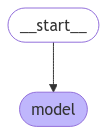

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
import uuid

# The thread id is a unique key that identifies
# this particular conversation.
# We'll just generate a random uuid here.
# This enables a single application to manage conversations among multiple users.
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}

print(config)

{'configurable': {'thread_id': UUID('9c750511-b744-4242-9936-2d8b034c18e6')}}


### **.invoke()**

In [33]:
from langchain_core.messages import HumanMessage

input_messages = HumanMessage(content="Hi! I'm Kanav")

response = graph.invoke({"messages": input_messages}, config)

In [34]:
print(response)

{'messages': [HumanMessage(content="Hi! I'm Kanav", additional_kwargs={}, response_metadata={}, id='7b74f923-53b8-4c23-bfa2-3f0de6b919fc'), AIMessage(content='Hello Kanav! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 33, 'total_tokens': 45, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3db7bbf4-7f36-4615-8c48-5d0d424aa17d-0', usage_metadata={'input_tokens': 33, 'output_tokens': 12, 'total_tokens': 45, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [35]:
# output contains all messages in state

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hi! I'm Kanav
================================== Ai Message ==================================

Hello Kanav! How can I assist you today?


### **.stream()**

In [36]:
from langchain_core.messages import HumanMessage

input_message = HumanMessage(content="What can you do for me?")

for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What can you do for me?
================================== Ai Message ==================================

I can help answer your questions, provide information on a wide range of topics, assist with tasks such as setting reminders or making lists, offer suggestions, and engage in general conversation. Feel free to ask me anything you'd like help with!


In [37]:
# Here, let's confirm that the AI remembers our name!
input_message = HumanMessage(content="what is my name?")

for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

Your name is Kanav.
